# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

# [1]. Reading Data

# Applying Decision Tree

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

# Mounting Google Drive locally

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
pip install paramiko

     |████████████████████████████████| 194kB 3.4MB/s 
     |████████████████████████████████| 768kB 41.8MB/s 
     |████████████████████████████████| 2.3MB 33kB/s 
     |████████████████████████████████| 61kB 22.9MB/s 
     |████████████████████████████████| 102kB 31.0MB/s 


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect("/content/gdrive/My Drive/Dataset/database.sqlite")



filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(87773, 10)

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:33<00:00, 2604.15it/s]


In [0]:
final["CleanText"] = [preprocessed_reviews[i] for i in range(len(final))]

In [0]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...


# [4] Featurization

In [0]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import seaborn as sns

from sklearn.metrics import confusion_matrix

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


In [0]:
Total_X = final['CleanText'].values
Total_y = final['Score'].values

In [0]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(Total_X, Total_y, test_size=0.33)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) 


In [0]:
print(f"Train Data : ({len(X_train)} , {len(y_train)})")
print(f"CV Data : ({len(X_cv)} , {len(y_cv)})")
print(f"Test Data : ({len(X_test)} , {len( y_test)})")

Train Data : (39400 , 39400)
CV Data : (19407 , 19407)
Test Data : (28966 , 28966)


## Decision Tree Training and Tesing Function

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [0]:
def DT(X_train_reg,X_cv_reg, y_train=y_train,  y_cv=y_cv,  y_test=y_test):

    max_depth = [5,7,8,9,10,11,12,13,15,17]
    min_samples_split = [5, 10, 100, 500]
    tuned_parameters = [{'max_depth': max_depth, 'min_samples_split':min_samples_split}]
    
    #Using GridSearchCV
    model = GridSearchCV(DecisionTreeClassifier( class_weight = "balanced"), tuned_parameters, n_jobs=2 ,scoring = 'roc_auc', cv=5, return_train_score=True)
    model.fit(X_train_reg, y_train)

    print(model.best_estimator_)
    print("_"*10)
    print("Best HyperParameter: ",model.best_params_)
    print(f"Best Accuracy: {model.best_score_*100}")
    
    tr_auc = model.cv_results_["mean_train_score"]
    cv_auc = model.cv_results_["mean_test_score"]
    
    reshape_tr_auc = tr_auc.reshape(len(max_depth),len( min_samples_split))
    reshape_cv_auc = cv_auc.reshape(len(max_depth),len( min_samples_split))
    

    ax = sns.heatmap(reshape_tr_auc, annot=True, fmt="g", cmap='viridis')
    plt.xlabel(" min_samples_split")
    plt.ylabel("max_depth")
    plt.show()
    
    

    sns.heatmap(reshape_cv_auc, annot=True, fmt="g", cmap='viridis')
    plt.xlabel(" min_samples_split")
    plt.ylabel("max_depth")
    plt.show()    

  
    

## Testing the max_depth with Test datapoints and Confusion Matrix

In [0]:
def testing_DT(X_train_reg,X_test_reg, max_d,min_s, y_train=y_train,  y_test=y_test):
    
    clf= DecisionTreeClassifier(max_depth =  max_d, min_samples_split =min_s, class_weight = "balanced")
    clf.fit(X_test_reg, y_test)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train_reg)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_reg)[:,1])
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.xscale(value = 'log')
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curves")
    plt.show()
    
    print(f" AUC score on test Data with max_depth = {max_d} and min_samples_split = {min_s } is :  {roc_auc_score(y_test, clf.predict(X_test_reg))* 100} %")
    
    
    print(f"Precision on test data: {precision_score(y_test, clf.predict(X_test_reg))}")
    print(f"Recall on test data: {recall_score(y_test, clf.predict(X_test_reg))}")
    print(f"F1-Score on test data: {f1_score(y_test, clf.predict(X_test_reg))}")
    
    print("\nConfusion Matrix of Train and Test set:\n [ [TN  FP]\n   [FN TP] ]\n")
    confusionMatrix_train=confusion_matrix(y_train, clf.predict(X_train_reg))
    confusionMatrix_test=confusion_matrix(y_test, clf.predict(X_test_reg))
    df_cm_tr = pd.DataFrame(confusionMatrix_train, range(2),range(2))
    df_cm_te = pd.DataFrame(confusionMatrix_test, range(2),range(2))
    plt.figure(figsize = (7,5))
    sns.set(font_scale=1)#for label size
    plt.ylabel("Predicted label")
    plt.xlabel("Actual label")
    plt.title("Confusion Matrix of Train Set")
   
    sns.heatmap(df_cm_tr, annot=True,annot_kws={"size": 12},fmt="d")

    plt.figure(figsize = (7,6))
    plt.ylabel("Predicted label")
    plt.xlabel("Actual label")
    plt.title("Confusion Matrix of Test Set")
    sns.heatmap(df_cm_te, annot=True,annot_kws={"size": 12},fmt="d")

## [4.1] BAG OF WORDS

## [5.1] Decision Tree on BOW,<font color='red'> SET 1</font>

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[1000:1010])
print('='*50)

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)


print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

some feature names  ['ama', 'amaazon', 'amade', 'amagic', 'amake', 'amalgamated', 'amalgamation', 'amaltose', 'amamzon', 'amanda']
After vectorizations
(39400, 37390) (39400,)
(19407, 37390) (19407,)
(28966, 37390) (28966,)


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=17,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
__________
Best HyperParameter:  {'max_depth': 17, 'min_samples_split': 500}
Best Accuracy: 80.40937877785423


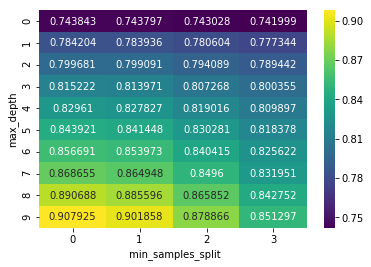

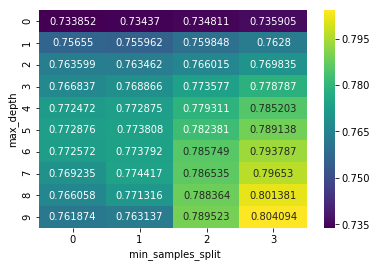

In [0]:
DT(X_train_bow,X_cv_bow)

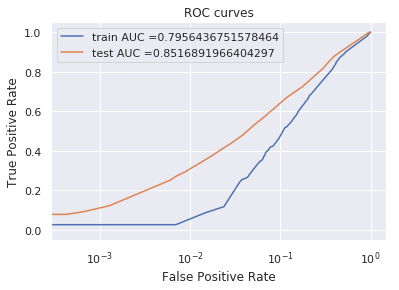

 AUC score on test Data with max_depth = 17 and min_samples_split = 500 is :  77.67813888203455 %
Precision on test data: 0.9635053329489767
Recall on test data: 0.6884732635741946
F1-Score on test data: 0.8030947403829981

Confusion Matrix of Train and Test set:
 [ [TN  FP]
   [FN TP] ]



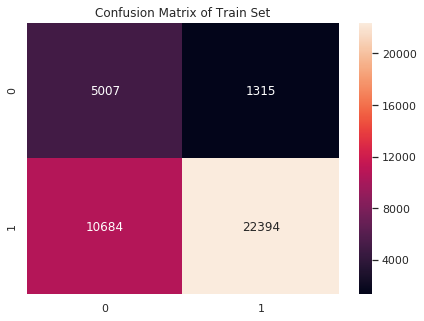

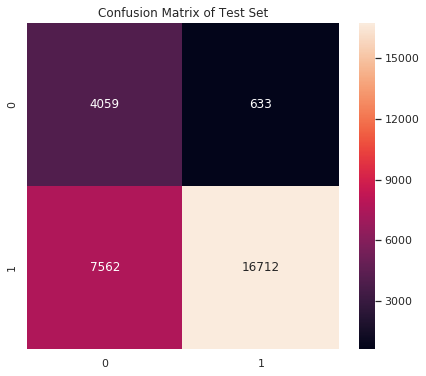

In [0]:
testing_DT(X_train_bow,X_test_bow,17,500)

### Tree Visualization

In [0]:
from sklearn import tree
import graphviz 
import pydotplus
from sklearn.tree import DecisionTreeClassifier, export_graphviz

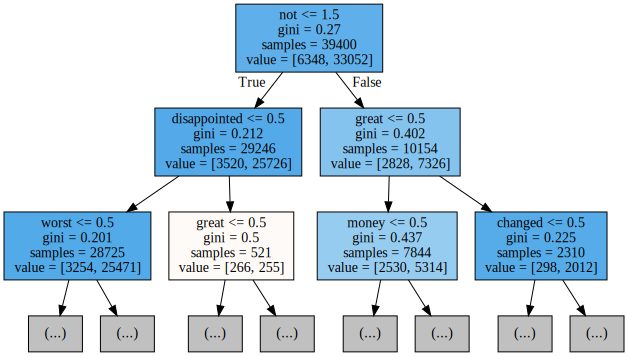

In [0]:
# Create and fit the decision tree
clf_dt = DecisionTreeClassifier(criterion = 'gini', max_depth = 3)
clf_dt.fit(X_train_bow, y_train)


# Visualize decision tree
export_graphviz(clf_dt, out_file="mytree.dot", feature_names = count_vect .get_feature_names(), max_depth = 2, filled = True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

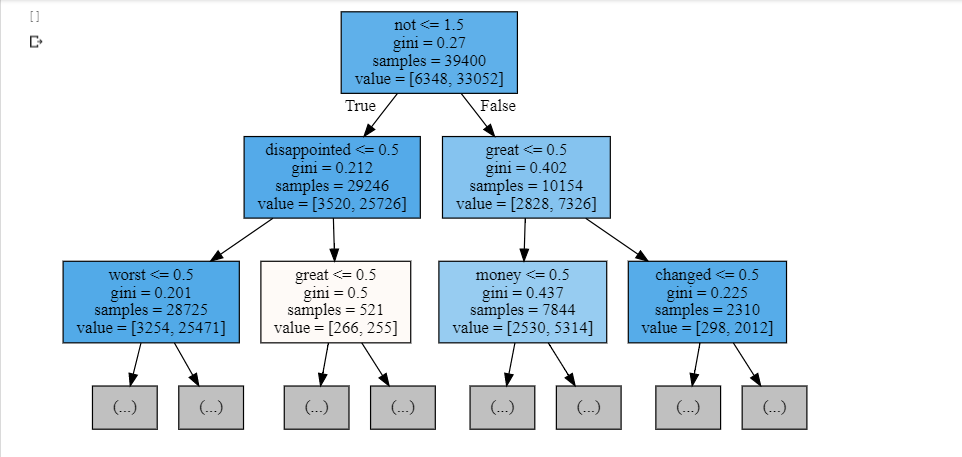

### [5.1.1] Top 10 important features of positive and negative class from<font color='red'> SET 1</font>

**Code reference:** https://www.datacamp.com/community/tutorials/wordcloud-python


https://python-graph-gallery.com/wordcloud/

https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

In [0]:
from wordcloud import WordCloud, STOPWORDS

In [0]:
def important_features(vect,max_depth,min_samples_split,X_train_reg, n):
    clf = DecisionTreeClassifier(max_depth = max_depth, min_samples_split=min_samples_split)
    clf.fit(X_train_reg, y_train) 
    
    features =vect.get_feature_names()
    coef = clf.feature_importances_
    coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
    df = coef_df.sort_values("coeficient", ascending = False)[:n]
    cloud = " ".join(word for word in df.word)
    stopwords = set(STOPWORDS) 
    wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 

    # plot the WordCloud image                        
    plt.figure(figsize = (10, 8)) 
    plt.imshow(wordcloud, interpolation = 'bilinear') 
    plt.axis("off") 
    plt.title(f"Top {n} most important features")
    plt.tight_layout(pad = 0) 

    plt.show()

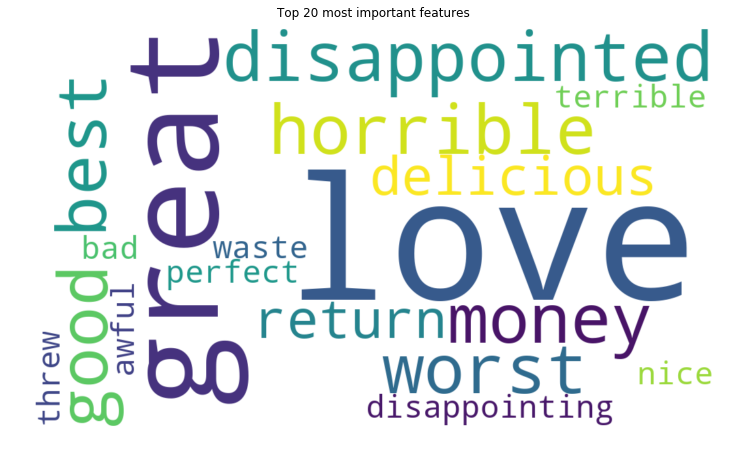

In [0]:
important_features(count_vect,50,500,X_train_bow,20)

## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

## [5.2] Decision Tree  on TFIDF, SET 2

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)


# we use the fitted CountVectorizer to convert the text to vector
X_train_tf_idf = tf_idf_vect.transform(X_train)
X_cv_tf_idf = tf_idf_vect.transform(X_cv)
X_test_tf_idf = tf_idf_vect.transform(X_test)


print("After vectorizations")
print(X_train_tf_idf.shape, y_train.shape)
print(X_cv_tf_idf.shape, y_cv.shape)
print(X_test_tf_idf.shape, y_test.shape)
print("="*100)

some sample features(unique words in the corpus) ['aa', 'ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able finish', 'able get']
After vectorizations
(39400, 23376) (39400,)
(19407, 23376) (19407,)
(28966, 23376) (28966,)


DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=17, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
__________
Best HyperParameter:  {'max_depth': 17, 'min_samples_split': 500}
Best Accuracy: 79.77144817744217


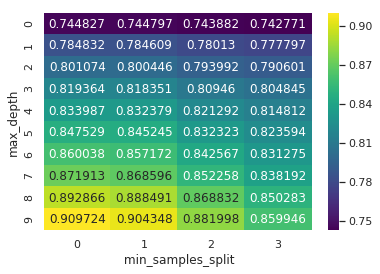

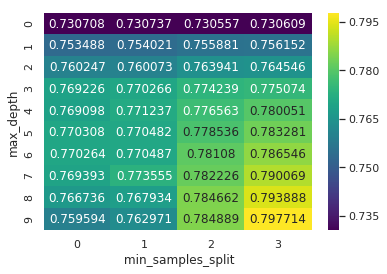

In [0]:
DT(X_train_tf_idf,X_cv_tf_idf)

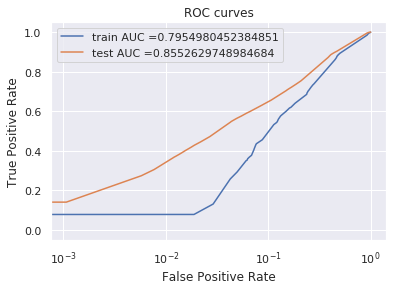

 AUC score on test Data with max_depth = 17 and min_samples_split = 500 is :  77.74655097413368 %
Precision on test data: 0.9596432552954292
Recall on test data: 0.7092362198236797
F1-Score on test data: 0.8156535746434831

Confusion Matrix of Train and Test set:
 [ [TN  FP]
   [FN TP] ]



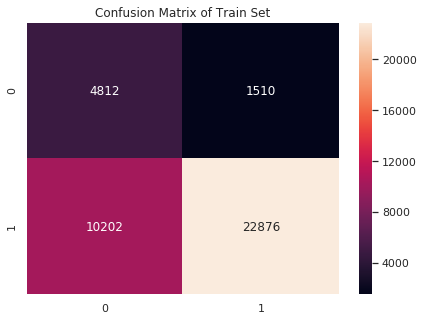

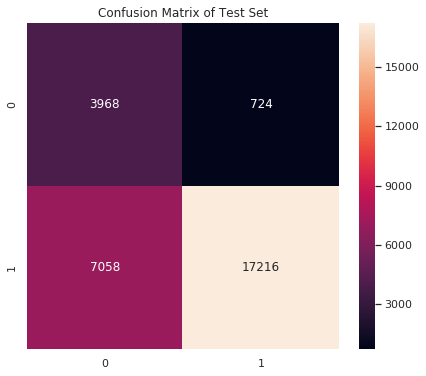

In [0]:
testing_DT(X_train_tf_idf,X_test_tf_idf,17,500)

Graphviz Reference: https://stackoverflow.com/questions/51346827/how-can-i-specify-the-figsize-of-a-graphviz-representation-of-decision-tree

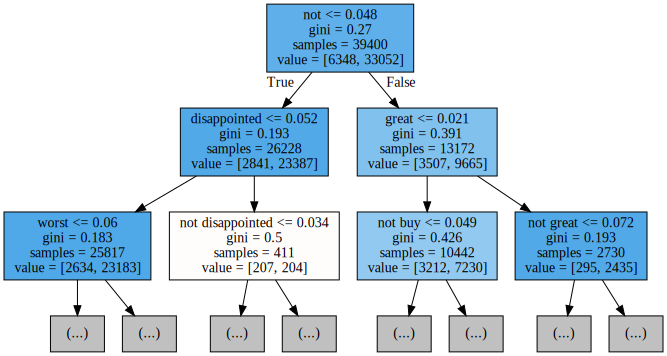

In [0]:

# Create and fit the decision tree
clf_dt = DecisionTreeClassifier(criterion = 'gini', max_depth = 3)
clf_dt.fit(X_train_tf_idf, y_train)


# Visualize decision tree
export_graphviz(clf_dt, out_file="mytree.dot", feature_names =tf_idf_vect .get_feature_names(), max_depth = 2, filled = True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

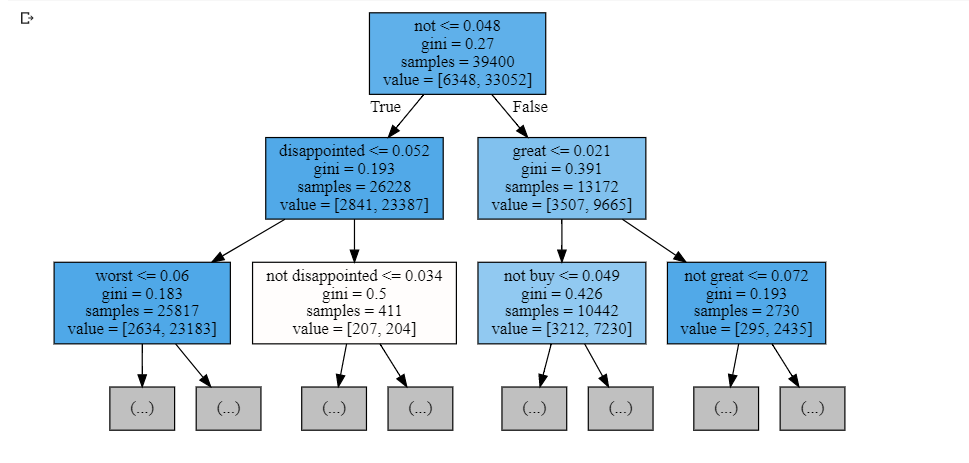

### [5.2.2] Top 10 important features of Positive and Negative class from<font color='red'> SET 2</font>

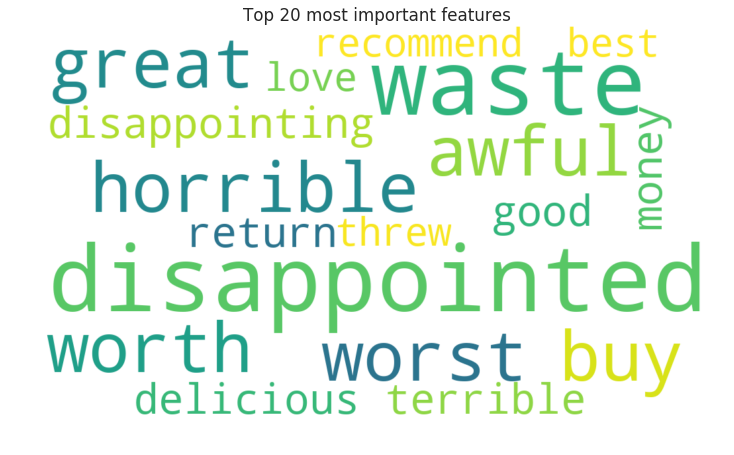

In [0]:
important_features(tf_idf_vect,50,500,X_train_tf_idf,20)

# [4.4] Word2Vec

In [0]:
i=0

w2v_train=[]
w2v_cv=[]
w2v_test=[]

for sentance in X_train:
    w2v_train.append(sentance.split())

for sentance in X_cv:
    w2v_cv.append(sentance.split())
    

for sentance in X_test:
    w2v_test.append(sentance.split())

In [0]:
want_to_train_w2v = True
if want_to_train_w2v:
# min_count = 5 considers only words that occured atleast 5 times
#w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    w2v_model_train = Word2Vec(w2v_train,min_count=5,size=50, workers=4)
    print(w2v_model_train.wv.most_similar('great'))
    print('='*50)
else:
    pass

[('good', 0.8189009428024292), ('fantastic', 0.8112022280693054), ('awesome', 0.8056771755218506), ('excellent', 0.7720053195953369), ('perfect', 0.7547230124473572), ('wonderful', 0.7492839694023132), ('terrific', 0.7487568259239197), ('amazing', 0.7365036606788635), ('decent', 0.7146030068397522), ('nice', 0.6910538077354431)]


In [0]:
w2v_words_train = list(w2v_model_train.wv.vocab)

print("number of words that occured minimum 5 times ",len(w2v_words_train ))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  11956
sample words  ['good', 'taste', 'price', 'no', 'sales', 'tax', 'shipping', 'charges', 'delivered', 'door', 'like', 'product', 'needs', 'better', 'way', 'packaging', 'items', 'prevent', 'broken', 'caps', 'lakewood', 'organic', 'pure', 'pomegranate', 'juice', 'expensive', 'compared', 'wild', 'oats', 'brand', 'not', 'flavor', 'outstanding', 'come', 'glass', 'bottles', 'definite', 'plus', 'plastic', 'reasonably', 'fast', 'packing', 'also', 'complaint', 'wish', 'would', 'fall', 'amazon', 'prime', 'alas']


#Converting text into vectors using Avg W2V, TFIDF-W2V

## [5.1.3] Applying Decision Tree  on AVG W2V, SET 3

### [4.4.1.1] Avg W2v

In [0]:
train_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(w2v_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
print()
print(len(train_vectors))
print(len(train_vectors[0]))

100%|██████████| 39400/39400 [01:00<00:00, 651.36it/s]


39400
50


In [0]:
# compute average word2vec for each review.
cv_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(w2v_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_vectors.append(sent_vec)
print()
print(len(cv_vectors))
print(len(cv_vectors[0]))

100%|██████████| 19407/19407 [00:29<00:00, 656.96it/s]


19407
50


In [0]:
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(w2v_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec =  w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print()
print(len(test_vectors))
print(len(test_vectors[0]))

100%|██████████| 28966/28966 [00:45<00:00, 636.98it/s]


28966
50


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
__________
Best HyperParameter:  {'max_depth': 9, 'min_samples_split': 500}
Best Accuracy: 81.93023623923258


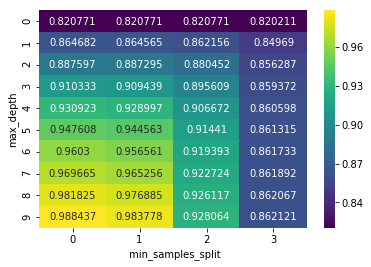

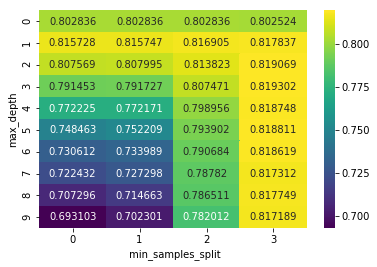

In [0]:
DT(train_vectors,cv_vectors)

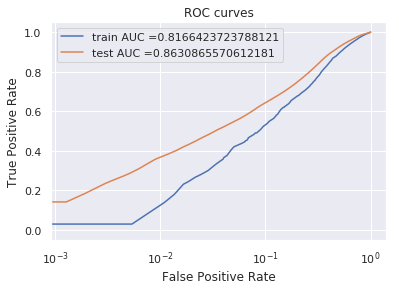

 AUC score on test Data with max_depth = 9 and min_samples_split = 500 is :  77.46807792760416 %
Precision on test data: 0.9612597706395847
Recall on test data: 0.6940759660542144
F1-Score on test data: 0.8061051171024618

Confusion Matrix of Train and Test set:
 [ [TN  FP]
   [FN TP] ]



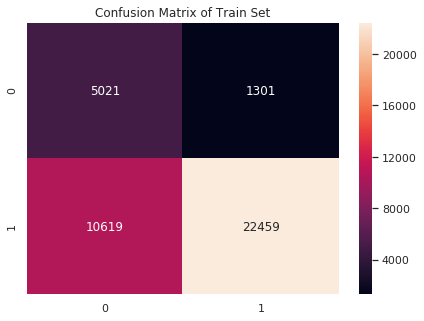

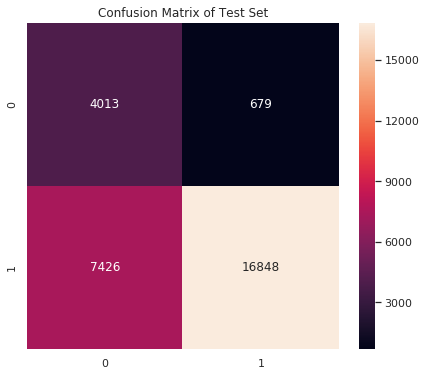

In [0]:
testing_DT(train_vectors, test_vectors,9,500)

## [5.4] Decision Tree  on TFIDF W2V

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(w2v_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 39400/39400 [12:24<00:00, 52.90it/s]


In [0]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

cv_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(w2v_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 19407/19407 [05:59<00:00, 53.93it/s]


In [0]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(w2v_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 28966/28966 [09:18<00:00, 51.85it/s]


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=11,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
__________
Best HyperParameter:  {'max_depth': 11, 'min_samples_split': 500}
Best Accuracy: 78.71242877637405


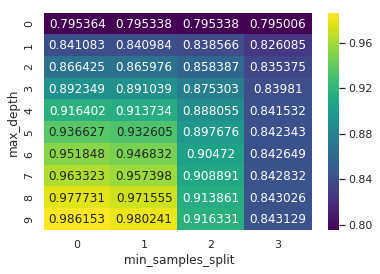

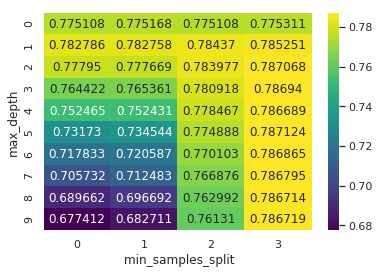

In [0]:
DT(train_tfidf_sent_vectors, cv_tfidf_sent_vectors)


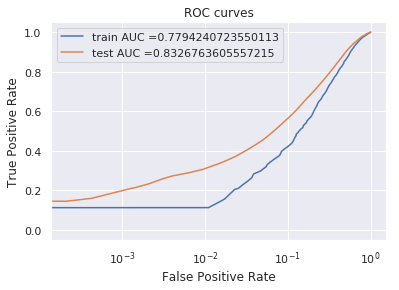

 AUC score on test Data with max_depth = 11 and min_samples_split = 500 is :  74.79909408085483 %
Precision on test data: 0.9494372393304005
Recall on test data: 0.6846008074482985
F1-Score on test data: 0.7955573640998634

Confusion Matrix of Train and Test set:
 [ [TN  FP]
   [FN TP] ]



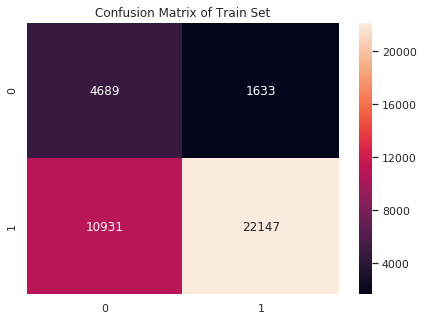

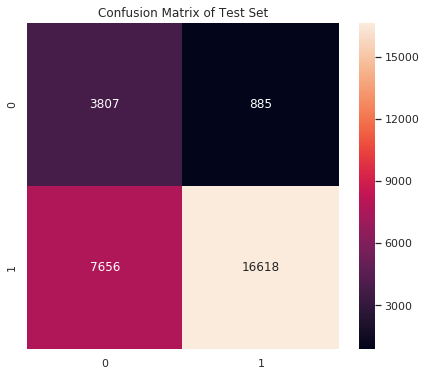

In [0]:
testing_DT(train_tfidf_sent_vectors, test_tfidf_sent_vectors,11,500)

# [6] Conclusions

In [0]:
from prettytable import PrettyTable

In [0]:


x = PrettyTable(["Vectorizer", "Model",  "Max_Depth",  "Min_samples_split",  "Train_AUC","Test_AUC"])



x.add_row(["BoW", "Decision Tree" , "17",  "500",  80.54, 77.67])
x.add_row(["Tf-Idf", "Decision Tree" , "17",  "500",  79.77,  77.64])
x.add_row(["AVG_W2V", "Decision Tree" , "9", "500",  81.93, 77.46])
x.add_row(["TFIDF_W2V", "Decision Tree" , "11",  "500", 78.72, 74.79])

print(x)




+------------+---------------+-----------+-------------------+-----------+----------+
| Vectorizer |     Model     | Max_Depth | Min_samples_split | Train_AUC | Test_AUC |
+------------+---------------+-----------+-------------------+-----------+----------+
|    BoW     | Decision Tree |     17    |        500        |   80.54   |  77.67   |
|   Tf-Idf   | Decision Tree |     17    |        500        |   79.77   |  77.64   |
|  AVG_W2V   | Decision Tree |     9     |        500        |   81.93   |  77.46   |
| TFIDF_W2V  | Decision Tree |     11    |        500        |   78.72   |  74.79   |
+------------+---------------+-----------+-------------------+-----------+----------+


# Observation:

**1) Decision Tree with AVG_W2V has given the lowest Test_Error.**

**2) Decision tree of AVG_W2V with depth = 9 is the lowest depth.**

***3) This model seems little better model as compare to other models. ***
